In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Import Libraries

In [2]:
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer,WordNetLemmatizer
import tensorflow as tf
from nltk.tokenize import word_tokenize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dropout,Dense,BatchNormalization
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

2024-07-31 12:36:40.689231: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 12:36:40.689377: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 12:36:40.862641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Read Datasets

In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

In [4]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [5]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
train_df.shape, test_df.shape

((7613, 5), (3263, 4))

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [10]:
train_df['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [11]:
train_df[['keyword','text','target']].head(50)

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,NaN,I'm on top of the hill and I can see a fire in...,1
8,NaN,There's an emergency evacuation happening now ...,1
9,NaN,I'm afraid that the tornado is coming to our a...,1


## Drop Unnecessary Columns

In [12]:
train_df.drop(columns=['keyword','location'],inplace=True)

In [13]:
test_df.drop(columns=['keyword','location'],inplace=True)

In [14]:
train_df

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [15]:
val_count = train_df['target'].value_counts()
val_count

target
0    4342
1    3271
Name: count, dtype: int64

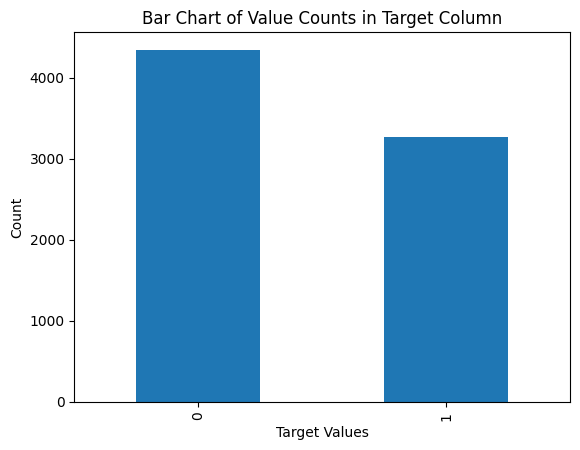

In [16]:
val_count.plot(kind='bar')
plt.xlabel('Target Values')
plt.ylabel('Count')
plt.title('Bar Chart of Value Counts in Target Column')
plt.show()

## Data Cleaning

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @mentions and hashtags
    text = re.sub(r'\@\w+|\#', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

In [20]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [21]:
train_df['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    control wild fires california even northern pa...
7610                                 utckm volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [22]:
train_df

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1
1,4,forest fire near la ronge sask canada,1
2,5,residents asked shelter place notified officer...,1
3,6,people receive wildfires evacuation orders cal...,1
4,7,got sent photo ruby alaska smoke wildfires pou...,1
...,...,...,...
7608,10869,two giant cranes holding bridge collapse nearb...,1
7609,10870,control wild fires california even northern pa...,1
7610,10871,utckm volcano hawaii,1
7611,10872,police investigating ebike collided car little...,1


In [23]:
stemmer = SnowballStemmer('english')

In [24]:
def stem_text(text):
    # Stem each word in the text
    return ' '.join([stemmer.stem(word) for word in text.split()])

In [25]:
train_df['text'] = train_df['text'].apply(stem_text)

In [26]:
test_df['text'] = test_df['text'].apply(stem_text)

In [27]:
train_df

,id,text,target
0,1,deed reason earthquak may allah forgiv us,1
1,4,forest fire near la rong sask canada,1
2,5,resid ask shelter place notifi offic evacu she...,1
3,6,peopl receiv wildfir evacu order california,1
4,7,got sent photo rubi alaska smoke wildfir pour ...,1
...,...,...,...
7608,10869,two giant crane hold bridg collaps nearbi home,1
7609,10870,control wild fire california even northern par...,1
7610,10871,utckm volcano hawaii,1
7611,10872,polic investig ebik collid car littl portug eb...,1


In [28]:
test_df

,id,text
0,0,happen terribl car crash
1,2,heard earthquak differ citi stay safe everyon
2,3,forest fire spot pond gees flee across street ...
3,9,apocalyps light spokan wildfir
4,11,typhoon soudelor kill china taiwan
...,...,...
3258,10861,earthquak safeti los angel ûò safeti fasten xrwn
3259,10865,storm ri wors last hurrican cityampoth hardest...
3260,10868,green line derail chicago
3261,10874,meg issu hazard weather outlook hwo


## Deep Learning

In [29]:
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(train_df['text'])
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

11883

In [30]:
longest_train = max(train_df['text'], key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

In [31]:
max_words = vocab_length
max_len = length_long_sentence
sequences = word_tokenizer.texts_to_sequences(train_df['text'])

padded_sequences = pad_sequences(sequences, maxlen=max_len)
labels = to_categorical(train_df['target'])

model = Sequential()
model.add(Embedding(max_words, 128))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='BinaryCrossentropy', optimizer='Adamax', metrics=['accuracy'])

model.fit(padded_sequences, labels, epochs=10, batch_size=64)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5732 - loss: 0.6755
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7331 - loss: 0.5684
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8138 - loss: 0.4335
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8381 - loss: 0.3825
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8491 - loss: 0.3566
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8651 - loss: 0.3350
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8758 - loss: 0.3026
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8816 - loss: 0.2886
Epoch 9/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8917 - loss: 0.2710
Epoch 10/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9058 - loss: 0.2424


In [32]:
sequences2 = word_tokenizer.texts_to_sequences(test_df['text'])
padded_sequences2 = pad_sequences(sequences2, maxlen=max_len)

In [33]:
predictions = model.predict(padded_sequences2)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [34]:
prob_class_1 = predictions[:, 1]
binary_predictions = [1 if p >= 0.5 else 0 for p in prob_class_1]
df = pd.DataFrame({'target': binary_predictions}, index=test_df['id'])
df.index.name = 'id'
df.to_csv('/kaggle/working/submission.csv')

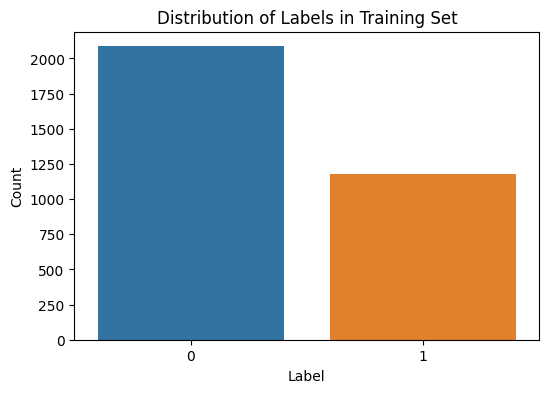

In [35]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [36]:
pd.read_csv('/kaggle/working/submission.csv')

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## Machine Learning

In [37]:
X = train_df['text']
y = train_df['target']

In [38]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [39]:
tfidf = TfidfVectorizer(max_features=5000,stop_words='english')

In [40]:
X_train = tfidf.fit_transform(X_train)

In [41]:
X_test = tfidf.transform(X_test)

## LogisticRegression

In [42]:
lr = LogisticRegression(max_iter=1000)

In [43]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [44]:
pred_y_lr = lr.predict(X_test)

In [45]:
accuracy_score(y_test,pred_y_lr)

0.788575180564675

## RandomForest

In [46]:
rf = RandomForestClassifier(n_estimators=71)

In [47]:
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=71)

In [48]:
y_pred_rf = rf.predict(X_test)

In [49]:
accuracy_score(y_test,y_pred_rf)

0.778069599474721